## Jeffrey Elkner

### Point Pattern Analysis
A subset of Atlantic tropical cyclone data for 1982-2009 period based on SHIPS database is provided. This subset contains only those TCs underwent rapid intensification process at the given time. In this assignment, only geolocations of the TC positions at given time are relevant. (Please use the projected data.)

### Problem 1: Nearest Neighbor 
Perform the nearest neighbor analysis on the give data points. Please give the values of Observed Mean Distance, Expected Mean Distance, Nearest Neighbor Ratio (R), Z-score, and p-value. Please also draw your conclusion on the spatial pattern of the RI location distribution. (15 points)

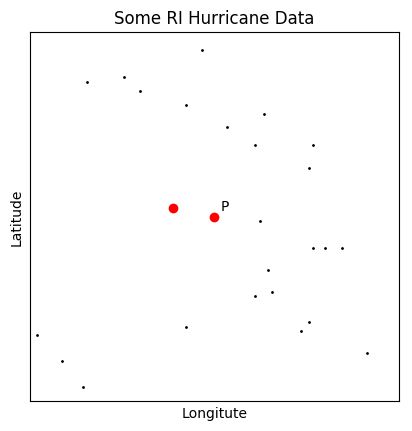

In [1]:
# https://tinyurl.com/averagenearestneighbor
# http://www.qgistutorials.com/en/docs/nearest_neighbor_analysis.html
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib.patches import Circle
import numpy as np
import thinkstats2 as ts
import shapefile
from ggs560.ggs560_tools import mean_center, standard_distance

def shape2dataframe(path2shape):
    sf = shapefile.Reader(path2shape)

    #grab the shapefile's field names (omit the first psuedo field)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]

    #write the records into a dataframe
    shpdf = pd.DataFrame(columns=fields, data=records)

    #add the coordinate data to a column called "coords"
    shpdf = shpdf.assign(coords=shps)
    
    return shpdf


def distance(p1, p2):
    """b
    Return the euclidean distance between to points.
    """
    return ((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)**0.5


def nearest_neighbor(point, points):
    """
    Return the nearest neighbor to the given point and the
    distance between the given point and its nearest neighbor.
    """
    # choose arbitrary point as "nearest"
    nn = points[0]
    dmin = distance(point, nn)
    
    # Now find closes point
    for p in points:
        # if p equals the given point, it isn't a "neighbor"
        if p[0] == point[0] and p[1] == point[1]:
            continue
        dp2p = distance(point, p)
        if dp2p < dmin:
            dmin = dp2p
            nn = p
    
    return nn, dmin

# Get the dataframe from the shapefile
df = shape2dataframe('Data/Projected_RI_Hurricanes/RI_1982-2009_Project')

# Create x and y lists for plotting and point tuples for nearest neighbor
xs = [point[0][0] for point in df.coords]
ys = [point[0][1] for point in df.coords]
points = list(zip(xs, ys))

# Pick a point in the middle and find nearest neighbor
p = points[len(points) // 2]
nn, d = nearest_neighbor(p, points)
    
# Now plot this to see if nn looks right
plt.scatter(xs, ys, c='k', s=1)
#plt.scatter([p[0]], [p[1]], c='r', s=1)
plt.plot([[p[0], nn[0]]], [[p[1], nn[1]]], 'or')
delta = 0.05e7
plt.xlim(p[0]-delta, p[0]+delta)
plt.xticks([])
plt.ylim(p[1]-delta, p[1]+delta)
plt.yticks([])
plt.gca().annotate('P', xy=(p[0], p[1]), xytext=(p[0] + delta/30, p[1] + delta/30))
plt.gca().set_aspect('equal')
plt.title('Some RI Hurricane Data')
plt.xlabel('Longitute')
plt.ylabel('Latitude')
plt.show()

In [2]:
# Compute the observed mean distance
# https://tinyurl.com/averagenearestneighbor
# https://github.com/cansik/LongLiveTheSquare

def observed_mean_distance(points):
    distances = 0
    for point in points:
        distances += nearest_neighbor(point, points)[1]
    # Since each distance was counted twice, divide by
    # 2 * number of points
    return distances / (2 * len(points))

omdist = observed_mean_distance(points)
print('The observed mean distance is {:0.2f}'.format(omdist))

The observed mean distance is 44010.16


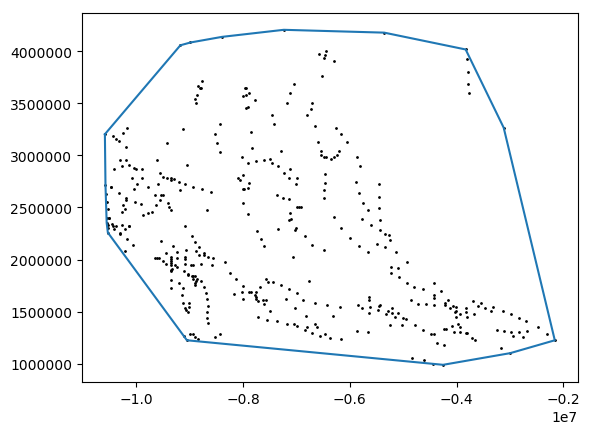

In [3]:
# Using code from
# https://en.wikibooks.org/wiki/Algorithm_Implementation/Geometry/Convex_hull/Monotone_chain

def convex_hull(points):
    points = sorted(set(points))

    if len(points) <= 1:
        return points

    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    return lower[:-1] + upper[:-1]

hull = convex_hull(points)
hx = [p[0] for p in hull] + [hull[0][0]]
hy = [p[1] for p in hull] + [hull[0][1]]

plt.plot(hx, hy)
plt.scatter(xs, ys, c='k', s=1)
plt.show()

In [4]:
# https://tinyurl.com/minboundingboxpython

### Problem 2: K-function
Perform the K-function analysis on the give data points. Please report
> (1) A table listing the expected K and observed K values and their differences. (5 points)

> (2) A plot of both expected and observed K values with envelope curves by using 99 permutation. (5 points)

> (3) Discuss the results on the spatial pattern and its relation to the distance. (5 points)

> (Optional/open end/extra credit) Tune the parameters and options in the ArcGIS for the K-function and discuss the resulting differences (quantitative/qualitative) due to the change of parameters and selection. (1-x points)

### Notes on the science part:
SHIPS (Statistical Hurricane Intensity Prediction Scheme) model for TC intensity forecasting is derived by regression analysis from a set of selected parameters sets (DeMaria & Kaplan 1994, 1999; DeMaria et al. 2005). The SHIPS data files can be found at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/. One of the data files for the period 1989-2009 hurricane season can be downloaded at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/2010/lsdiaga_1982_2009_rean_biascorr_sat.dat, and the corresponding document file for this data file is also available at ftp://rammftp.cira.colostate.edu/demaria/SHIPS/2009/SHIPS_predictor_file_2009.doc. The original data are in ASCII but the data are hard to handle.
Rapid intensification (RI) is defined as rapid intensity increase in a short time, typically 30 knots of wind increase in 24 hours (Kaplan and DeMaria 2003; Yang et al. 2007; Kaplan et al. 2010). RI is relatively rare cases with a probability around 5% overall.


### References: 
Kaplan, J. and M. DeMaria (2003), Large-scale characteristics of rapidly intensifying tropical cyclones in the North Atlantic basin, Wea. Forecasting, 18, 1093-1108.

Kaplan, J., M. DeMaria, and J.A. Knaff (2010): A revised tropical cyclone rapid intensification index for the Atlantic and east Pacific basins. Wea. Forecasting, 25, 220-241. 

Yang, R., J. Tang, and M. Kafatos (2007), “Improved associated conditions in rapid intensifications of tropical cyclones,” Geophys. Res. Lett., 34, L20807, doi:10.1029/2007GL031241. 

DeMaria, M., and J. Kaplan, 1994b:  A statistical hurricane intensity prediction scheme (SHIPS) for the Atlantic basin, Wea. Forecasting, 9, 209-220. 

DeMaria, M. and J. Kaplan, 1999:  An Updated Statistical Hurricane Intensity Prediction Scheme (SHIPS) for the Atlantic and Eastern North Pacific Basins Mark, Wea. Forecasting, 14, 326–337. 

DeMaria, M., M. Mainelli,  L. K. Shay,  J. A. Knaff, and J. Kaplan, 2005:  Further Improvements to the Statistical Hurricane Intensity Prediction Scheme (SHIPS), Wea. Forecasting, 20, 531–543.